In [6]:
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from rasterio.features import geometry_mask
from rasterio.mask import mask
from rasterio.windows import Window

In [7]:
from rasterio.merge import merge
from rasterio.transform import from_origin
from rasterio.warp import calculate_default_transform, reproject, Resampling

# List of TIF file paths
tif_files = ["cdnc43e.tif", "cdnc43f.tif", "cdnc43k.tif", "cdnc43l.tif"]

# Create a list to store opened TIF datasets
datasets = []

# Open all TIF files and add them to the datasets list
for tif_file in tif_files:
    dataset = rasterio.open(tif_file)
    datasets.append(dataset)

# Merge the datasets into a single mosaic
mosaic, out_transform = merge(datasets)

# Calculate the dimensions of the mosaic
mosaic_width = mosaic.shape[2]
mosaic_height = mosaic.shape[1]

# Create a new TIF file for the mosaic
mosaic_output_path = "mosaic.tif"
with rasterio.open(
    mosaic_output_path,
    'w',
    driver='GTiff',
    width=mosaic_width,
    height=mosaic_height,
    count=mosaic.shape[0],
    dtype=mosaic.dtype,
    crs=datasets[0].crs,
    transform=out_transform,
) as mosaic_dataset:
    mosaic_dataset.write(mosaic)

# Close all opened datasets
for dataset in datasets:
    dataset.close()

print("Mosaic created and saved to", mosaic_output_path)


Mosaic created and saved to mosaic.tif


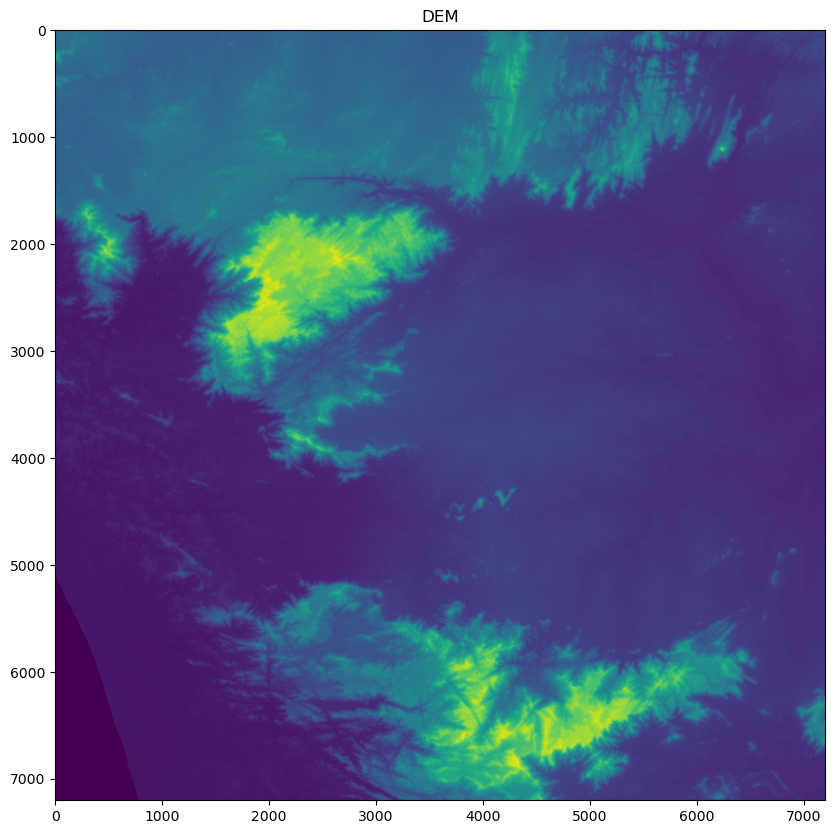

In [8]:
with rasterio.open('mosaic.tif') as src:
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(src.read(1))
    ax.set_title('DEM')
    plt.show()

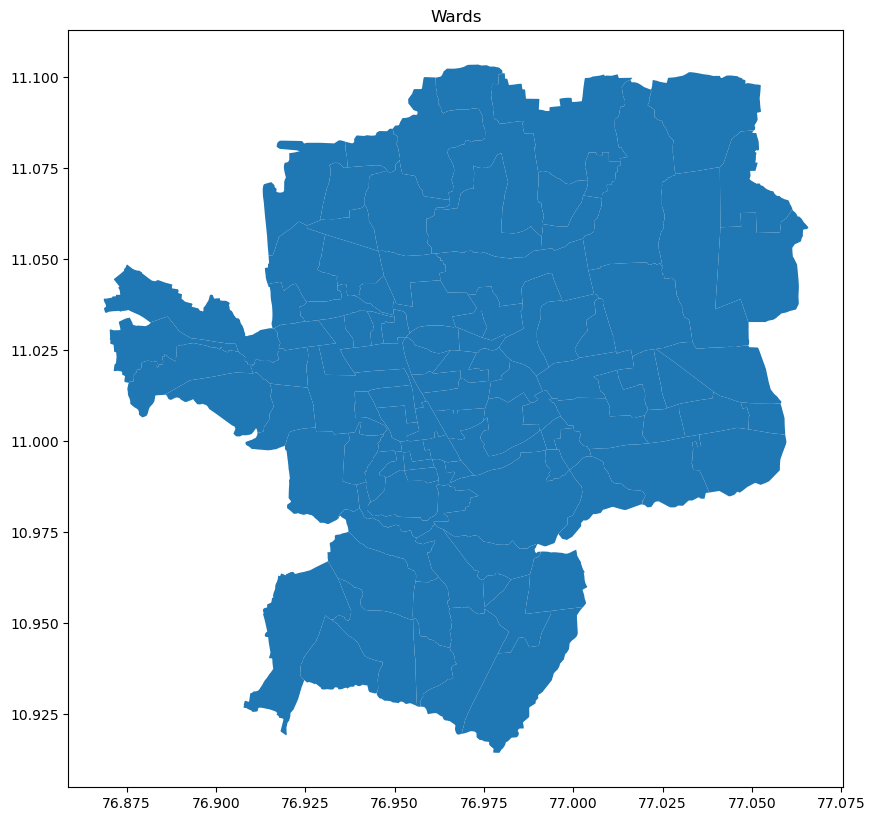

In [9]:
wards = gpd.read_file('Cbe2011Wards.shp')
fig, ax = plt.subplots(figsize=(10, 10))
wards.plot(ax=ax)
ax.set_title('Wards')
plt.show()

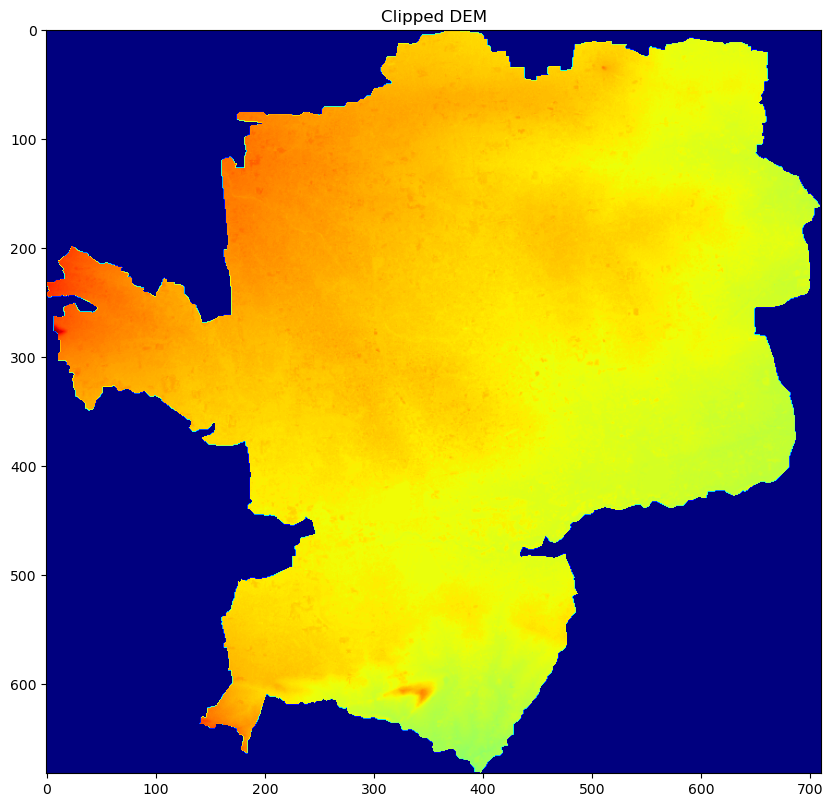

In [17]:
with rasterio.open('mosaic.tif') as src:
    out_image, out_transform = mask(src, wards.geometry, crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})
    with rasterio.open("clipped.tif", "w", **out_meta) as dest:
        dest.write(out_image)

with rasterio.open('clipped.tif') as src:
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(src.read(1), cmap='jet')
    ax.set_title('Clipped DEM')
    plt.show()

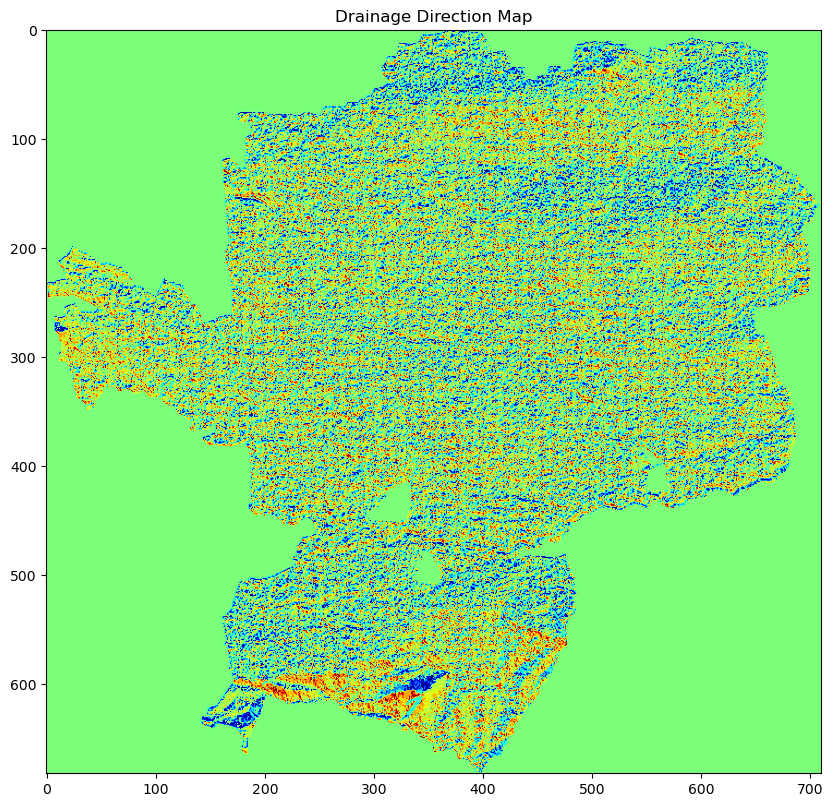

In [11]:
with rasterio.open('clipped.tif') as src:
    dem = src.read(1)
    rows, cols = dem.shape
    d8 = np.zeros((rows, cols), dtype=np.int8)
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            d8[i, j] = 0
            if dem[i, j] > dem[i - 1, j]:
                d8[i, j] += 1
            if dem[i, j] > dem[i - 1, j + 1]:
                d8[i, j] += 2
            if dem[i, j] > dem[i, j + 1]:
                d8[i, j] += 4
            if dem[i, j] > dem[i + 1, j + 1]:
                d8[i, j] += 8
            if dem[i, j] > dem[i + 1, j]:
                d8[i, j] += 16
            if dem[i, j] > dem[i + 1, j - 1]:
                d8[i, j] += 32
            if dem[i, j] > dem[i, j - 1]:
                d8[i, j] += 64
            if dem[i, j] > dem[i - 1, j - 1]:
                d8[i, j] += 128

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(d8, cmap='jet')
ax.set_title('Drainage Direction Map')
plt.show()

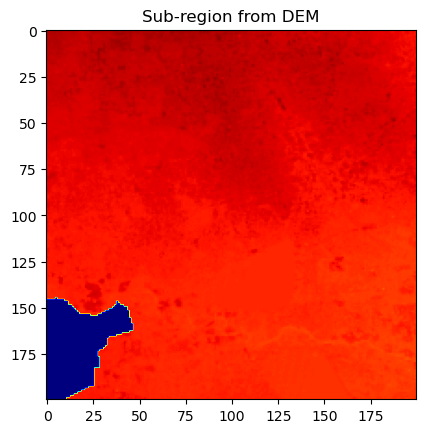

In [21]:
with rasterio.open('clipped.tif') as src:
    transform = src.transform
    full_dem = src.read(1)
    
    x_center, y_center = 300, 400  
    
    radius = 100
    
    col_off = x_center - radius
    row_off = y_center - radius
    width = height = 2 * radius
    
    window = Window(col_off=col_off, row_off=row_off, width=width, height=height)
    sub_dem = src.read(1, window=window)
    
    plt.imshow(sub_dem, cmap='jet')
    plt.title('Sub-region from DEM')
    plt.show()

with rasterio.open('sub_dem.tif', 'w', **src.meta) as dst:
    dst.write(sub_dem, 1)

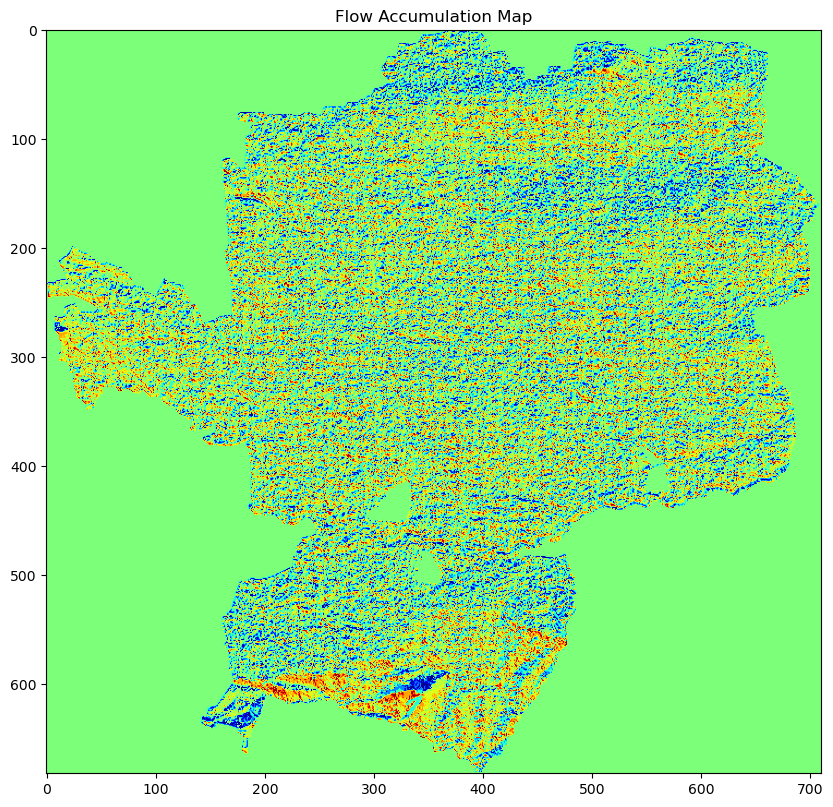

In [43]:
with rasterio.open('clipped.tif') as src:
    dem = src.read(1)
    rows, cols = dem.shape
    d8 = np.zeros((rows, cols), dtype=np.int8)
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            d8[i, j] = 0
            if dem[i, j] > dem[i - 1, j]:
                d8[i, j] += 1
            if dem[i, j] > dem[i - 1, j + 1]:
                d8[i, j] += 2
            if dem[i, j] > dem[i, j + 1]:
                d8[i, j] += 4
            if dem[i, j] > dem[i + 1, j + 1]:
                d8[i, j] += 8
            if dem[i, j] > dem[i + 1, j]:
                d8[i, j] += 16
            if dem[i, j] > dem[i + 1, j - 1]:
                d8[i, j] += 32
            if dem[i, j] > dem[i, j - 1]:
                d8[i, j] += 64
            if dem[i, j] > dem[i - 1, j - 1]:
                d8[i, j] += 128

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(d8, cmap='jet')
ax.set_title('Flow Accumulation Map')
plt.show()

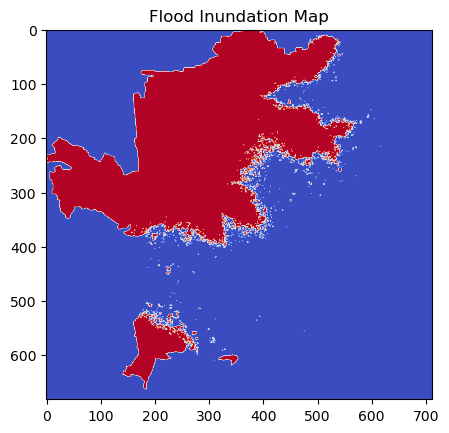

In [41]:
with rasterio.open('clipped.tif') as src:
    transform = src.transform
    full_dem = src.read(1)

    flood_level = 330
    flood_depth = 10

    flood_map = np.where(full_dem > flood_level, flood_depth, 0)

    plt.imshow(flood_map,cmap='coolwarm')
    plt.title('Flood Inundation Map')
    plt.show()

In [39]:
import rasterio

# Open the GeoTIFF file with elevation data
with rasterio.open('clipped.tif') as src:
    # Read the entire elevation dataset
    elevation_data = src.read(1)

# Iterate through all elevation values and print non-zero values
for row in elevation_data:
    for elevation in row:
        if elevation != 0:
            print(f'Elevation: {elevation} meters')


Elevation: 336 meters
Elevation: 338 meters
Elevation: 339 meters
Elevation: 336 meters
Elevation: 336 meters
Elevation: 331 meters
Elevation: 333 meters
Elevation: 333 meters
Elevation: 335 meters
Elevation: 334 meters
Elevation: 333 meters
Elevation: 334 meters
Elevation: 333 meters
Elevation: 333 meters
Elevation: 333 meters
Elevation: 340 meters
Elevation: 340 meters
Elevation: 342 meters
Elevation: 341 meters
Elevation: 338 meters
Elevation: 336 meters
Elevation: 334 meters
Elevation: 334 meters
Elevation: 334 meters
Elevation: 334 meters
Elevation: 334 meters
Elevation: 334 meters
Elevation: 333 meters
Elevation: 333 meters
Elevation: 334 meters
Elevation: 334 meters
Elevation: 334 meters
Elevation: 332 meters
Elevation: 333 meters
Elevation: 333 meters
Elevation: 333 meters
Elevation: 332 meters
Elevation: 332 meters
Elevation: 333 meters
Elevation: 337 meters
Elevation: 341 meters
Elevation: 340 meters
Elevation: 338 meters
Elevation: 340 meters
Elevation: 343 meters
Elevation:

Elevation: 328 meters
Elevation: 330 meters
Elevation: 328 meters
Elevation: 329 meters
Elevation: 330 meters
Elevation: 330 meters
Elevation: 329 meters
Elevation: 326 meters
Elevation: 326 meters
Elevation: 327 meters
Elevation: 328 meters
Elevation: 325 meters
Elevation: 324 meters
Elevation: 323 meters
Elevation: 322 meters
Elevation: 322 meters
Elevation: 323 meters
Elevation: 322 meters
Elevation: 320 meters
Elevation: 319 meters
Elevation: 320 meters
Elevation: 321 meters
Elevation: 320 meters
Elevation: 321 meters
Elevation: 322 meters
Elevation: 317 meters
Elevation: 319 meters
Elevation: 320 meters
Elevation: 321 meters
Elevation: 320 meters
Elevation: 317 meters
Elevation: 317 meters
Elevation: 317 meters
Elevation: 316 meters
Elevation: 315 meters
Elevation: 315 meters
Elevation: 316 meters
Elevation: 315 meters
Elevation: 314 meters
Elevation: 313 meters
Elevation: 313 meters
Elevation: 314 meters
Elevation: 314 meters
Elevation: 315 meters
Elevation: 314 meters
Elevation:

Elevation: 384 meters
Elevation: 384 meters
Elevation: 383 meters
Elevation: 383 meters
Elevation: 382 meters
Elevation: 381 meters
Elevation: 382 meters
Elevation: 380 meters
Elevation: 380 meters
Elevation: 380 meters
Elevation: 380 meters
Elevation: 380 meters
Elevation: 380 meters
Elevation: 379 meters
Elevation: 384 meters
Elevation: 387 meters
Elevation: 388 meters
Elevation: 384 meters
Elevation: 379 meters
Elevation: 381 meters
Elevation: 378 meters
Elevation: 377 meters
Elevation: 377 meters
Elevation: 378 meters
Elevation: 380 meters
Elevation: 380 meters
Elevation: 377 meters
Elevation: 374 meters
Elevation: 376 meters
Elevation: 376 meters
Elevation: 377 meters
Elevation: 377 meters
Elevation: 374 meters
Elevation: 374 meters
Elevation: 374 meters
Elevation: 374 meters
Elevation: 376 meters
Elevation: 373 meters
Elevation: 373 meters
Elevation: 371 meters
Elevation: 371 meters
Elevation: 370 meters
Elevation: 370 meters
Elevation: 370 meters
Elevation: 369 meters
Elevation:

Elevation: 331 meters
Elevation: 330 meters
Elevation: 330 meters
Elevation: 329 meters
Elevation: 328 meters
Elevation: 327 meters
Elevation: 328 meters
Elevation: 331 meters
Elevation: 332 meters
Elevation: 331 meters
Elevation: 331 meters
Elevation: 330 meters
Elevation: 330 meters
Elevation: 329 meters
Elevation: 329 meters
Elevation: 329 meters
Elevation: 329 meters
Elevation: 325 meters
Elevation: 324 meters
Elevation: 324 meters
Elevation: 325 meters
Elevation: 326 meters
Elevation: 326 meters
Elevation: 325 meters
Elevation: 325 meters
Elevation: 331 meters
Elevation: 331 meters
Elevation: 324 meters
Elevation: 324 meters
Elevation: 325 meters
Elevation: 325 meters
Elevation: 326 meters
Elevation: 324 meters
Elevation: 327 meters
Elevation: 323 meters
Elevation: 329 meters
Elevation: 329 meters
Elevation: 328 meters
Elevation: 328 meters
Elevation: 329 meters
Elevation: 328 meters
Elevation: 328 meters
Elevation: 328 meters
Elevation: 329 meters
Elevation: 330 meters
Elevation:

Elevation: 365 meters
Elevation: 365 meters
Elevation: 364 meters
Elevation: 363 meters
Elevation: 361 meters
Elevation: 365 meters
Elevation: 372 meters
Elevation: 363 meters
Elevation: 364 meters
Elevation: 363 meters
Elevation: 365 meters
Elevation: 365 meters
Elevation: 360 meters
Elevation: 360 meters
Elevation: 360 meters
Elevation: 363 meters
Elevation: 362 meters
Elevation: 360 meters
Elevation: 359 meters
Elevation: 359 meters
Elevation: 361 meters
Elevation: 362 meters
Elevation: 360 meters
Elevation: 358 meters
Elevation: 357 meters
Elevation: 357 meters
Elevation: 358 meters
Elevation: 358 meters
Elevation: 362 meters
Elevation: 361 meters
Elevation: 357 meters
Elevation: 354 meters
Elevation: 358 meters
Elevation: 358 meters
Elevation: 359 meters
Elevation: 357 meters
Elevation: 350 meters
Elevation: 352 meters
Elevation: 354 meters
Elevation: 353 meters
Elevation: 354 meters
Elevation: 351 meters
Elevation: 354 meters
Elevation: 353 meters
Elevation: 353 meters
Elevation:

Elevation: 360 meters
Elevation: 363 meters
Elevation: 361 meters
Elevation: 359 meters
Elevation: 361 meters
Elevation: 357 meters
Elevation: 357 meters
Elevation: 357 meters
Elevation: 358 meters
Elevation: 359 meters
Elevation: 359 meters
Elevation: 359 meters
Elevation: 359 meters
Elevation: 358 meters
Elevation: 355 meters
Elevation: 358 meters
Elevation: 360 meters
Elevation: 354 meters
Elevation: 354 meters
Elevation: 355 meters
Elevation: 355 meters
Elevation: 356 meters
Elevation: 357 meters
Elevation: 357 meters
Elevation: 356 meters
Elevation: 358 meters
Elevation: 357 meters
Elevation: 354 meters
Elevation: 353 meters
Elevation: 352 meters
Elevation: 354 meters
Elevation: 355 meters
Elevation: 353 meters
Elevation: 354 meters
Elevation: 354 meters
Elevation: 353 meters
Elevation: 351 meters
Elevation: 349 meters
Elevation: 349 meters
Elevation: 350 meters
Elevation: 352 meters
Elevation: 352 meters
Elevation: 351 meters
Elevation: 350 meters
Elevation: 350 meters
Elevation:

Elevation: 293 meters
Elevation: 295 meters
Elevation: 294 meters
Elevation: 293 meters
Elevation: 291 meters
Elevation: 292 meters
Elevation: 293 meters
Elevation: 294 meters
Elevation: 293 meters
Elevation: 292 meters
Elevation: 292 meters
Elevation: 293 meters
Elevation: 294 meters
Elevation: 292 meters
Elevation: 292 meters
Elevation: 292 meters
Elevation: 291 meters
Elevation: 291 meters
Elevation: 293 meters
Elevation: 293 meters
Elevation: 292 meters
Elevation: 293 meters
Elevation: 300 meters
Elevation: 299 meters
Elevation: 298 meters
Elevation: 303 meters
Elevation: 301 meters
Elevation: 303 meters
Elevation: 300 meters
Elevation: 302 meters
Elevation: 300 meters
Elevation: 294 meters
Elevation: 295 meters
Elevation: 291 meters
Elevation: 423 meters
Elevation: 424 meters
Elevation: 421 meters
Elevation: 420 meters
Elevation: 419 meters
Elevation: 418 meters
Elevation: 417 meters
Elevation: 415 meters
Elevation: 414 meters
Elevation: 416 meters
Elevation: 414 meters
Elevation:

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Elevation: 319 meters
Elevation: 320 meters
Elevation: 326 meters
Elevation: 326 meters
Elevation: 325 meters
Elevation: 325 meters
Elevation: 326 meters
Elevation: 327 meters
Elevation: 329 meters
Elevation: 324 meters
Elevation: 324 meters
Elevation: 324 meters
Elevation: 325 meters
Elevation: 337 meters
Elevation: 337 meters
Elevation: 339 meters
Elevation: 341 meters
Elevation: 341 meters
Elevation: 339 meters
Elevation: 340 meters
Elevation: 341 meters
Elevation: 341 meters
Elevation: 339 meters
Elevation: 337 meters
Elevation: 336 meters
Elevation: 337 meters
Elevation: 338 meters
Elevation: 336 meters
Elevation: 334 meters
Elevation: 334 meters
Elevation: 335 meters
Elevation: 338 meters
Elevation: 337 meters
Elevation: 334 meters
Elevation: 333 meters
Elevation: 334 meters
Elevation: 334 meters
Elevation: 332 meters
Elevation: 334 meters
Elevation: 333 meters
Elevation: 333 meters
Elevation: 333 meters
Elevation: 334 meters
Elevation: 334 meters
Elevation: 331 meters
Elevation:

Elevation: 335 meters
Elevation: 332 meters
Elevation: 331 meters
Elevation: 329 meters
Elevation: 327 meters
Elevation: 324 meters
Elevation: 322 meters
Elevation: 320 meters
Elevation: 320 meters
Elevation: 320 meters
Elevation: 319 meters
Elevation: 321 meters
Elevation: 323 meters
Elevation: 323 meters
Elevation: 322 meters
Elevation: 323 meters
Elevation: 324 meters
Elevation: 326 meters
Elevation: 324 meters
Elevation: 325 meters
Elevation: 324 meters
Elevation: 323 meters
Elevation: 328 meters
Elevation: 325 meters
Elevation: 327 meters
Elevation: 325 meters
Elevation: 328 meters
Elevation: 328 meters
Elevation: 328 meters
Elevation: 324 meters
Elevation: 327 meters
Elevation: 324 meters
Elevation: 316 meters
Elevation: 316 meters
Elevation: 317 meters
Elevation: 317 meters
Elevation: 313 meters
Elevation: 316 meters
Elevation: 314 meters
Elevation: 312 meters
Elevation: 311 meters
Elevation: 312 meters
Elevation: 308 meters
Elevation: 305 meters
Elevation: 306 meters
Elevation:

Elevation: 269 meters
Elevation: 266 meters
Elevation: 266 meters
Elevation: 263 meters
Elevation: 261 meters
Elevation: 261 meters
Elevation: 261 meters
Elevation: 260 meters
Elevation: 260 meters
Elevation: 260 meters
Elevation: 264 meters
Elevation: 262 meters
Elevation: 263 meters
Elevation: 265 meters
Elevation: 267 meters
Elevation: 267 meters
Elevation: 266 meters
Elevation: 267 meters
Elevation: 266 meters
Elevation: 266 meters
Elevation: 265 meters
Elevation: 263 meters
Elevation: 263 meters
Elevation: 261 meters
Elevation: 261 meters
Elevation: 261 meters
Elevation: 261 meters
Elevation: 261 meters
Elevation: 264 meters
Elevation: 263 meters
Elevation: 258 meters
Elevation: 259 meters
Elevation: 260 meters
Elevation: 263 meters
Elevation: 264 meters
Elevation: 265 meters
Elevation: 266 meters
Elevation: 268 meters
Elevation: 268 meters
Elevation: 269 meters
Elevation: 270 meters
Elevation: 271 meters
Elevation: 271 meters
Elevation: 271 meters
Elevation: 375 meters
Elevation:

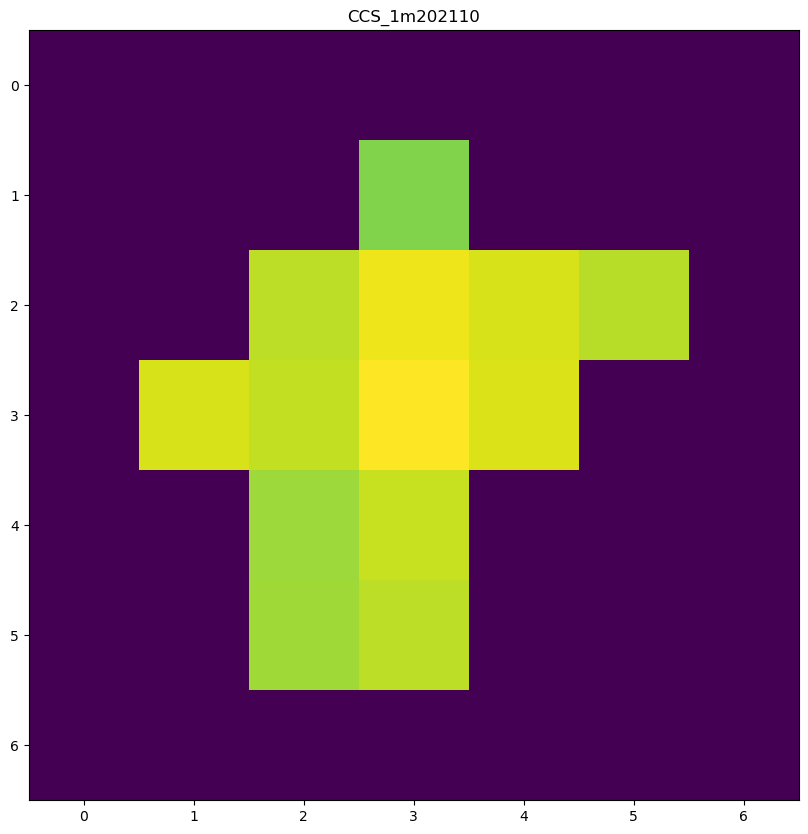

In [31]:
with rasterio.open('CCS_1m202110.tif') as src:
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(src.read(1))
    ax.set_title('CCS_1m202110')
    plt.show()